<a href="https://colab.research.google.com/github/krrish9973/pytorch-deep-learning/blob/main/Exploring_Pytorch_2_x_compile()_method_using_ResNet50_using_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What we're going to cover

Namely we'll make two of the same models, one using the default PyTorch setup and the other using the new `torch.compile()` setup and we'll train them on the same dataset.

1. Model 1 - no `torch.compile()`.
2. Model 2 - `torch.compile()`.

We'll then compare the training/testing times of both models for single run and multiple runs.

| Experiment       | Model    | Data    | Epochs | Batch size | Image size | torch.compile() |
|------------------|----------|---------|--------|-------------|-------------|------------------|
| 1 (single run)   | ResNet50 | CIFAR10 | 5      | 128         | 224         | No               |
| 2 (single run)   | ResNet50 | CIFAR10 | 5      | 128         | 224         | Yes              |
| 3 (multi-run)    | ResNet50 | CIFAR10 | 3x5    | 128         | 224         | No               |
| 4 (multi-run)    | ResNet50 | CIFAR10 | 3x5    | 128         | 224           | Yes                |


## 1. Get GPU info

In [ ]:
import torch

# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.x, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: NVIDIA_A100-SXM4-40GB
GPU capability score: (8, 0)
GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.
GPU information:
Sat Jun 28 11:12:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             46W /  400W |       5MiB /  40960MiB |    

### 1.1 Globally set devices

In [ ]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
    # All tensors created in this block will be on device
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weights are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [ ]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device globally
torch.set_default_device(device)

# All tensors created will be on the global device by default
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [ ]:
#Now Back to CPU

import torch

# Set the device globally
torch.set_default_device("cpu")

# All tensors created will be on "cpu"
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


## 2. Setting up the experiments

To keep things simple, as we discussed we're going to run a series of four experiments, all with:

> Model: `ResNet50` (from TorchVision)

> Data: `CIFAR10` (from TorchVision)

> Epochs: 5 (single run) and 3x5 (multiple runs)

> `Batch size`: 128

> `Image size`: 224

Each experiment will be run with and without `torch.compile()`.

Why the single and multiple runs?

Because we can measure speedups via a single run, however, we'll also want to run the tests multiple times to get an average (just to make sure the results from a single run weren't a fluke or something went wrong).



In [ ]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
Using device: cuda


### 2.1 Create model and transforms

We'll count the model's parameters to see how big of a model we're working with. The more parameters in a model, the larger GPU memory you'll need to train it. However, the more parameters your model has, the more GPU memory it uses, the larger relative speedup you'll often see. Meaning, a larger model may take longer to train in total, however, on a relative basis because it's using more GPU power, it could be faster than a smaller model. As in, a model with 10M parameters may take only 5x longer to train than a model with 1M parameters (10x the size but only 5x the training time).

In [ ]:
# Create model weights and transforms
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # <- use the latest weights (could also use .DEFAULT)
transforms = model_weights.transforms()

# Setup model
model = torchvision.models.resnet50(weights=model_weights)

# Count the number of parameters in the model
total_params = sum(
    param.numel() for param in model.parameters() # <- all params
	# param.numel() for param in model.parameters() if param.requires_grad # <- only trainable params
)

print(f"Total parameters of model: {total_params} (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)")
print(f"Model transforms:\n{transforms}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)

  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048,
                             out_features=num_classes)
  return model, transforms

model, transforms = create_model()

### 2.2 Speedups are most noticeable when a large portion of the GPU is being used

Since modern GPUs are so fast at performing operations, you will often notice the majority of relative speedups when as much data as possible is on the GPU.

This can be achieved by:

1. **Increasing the batch size** - More samples per batch means more samples on the GPU, for example, using a batch size of 256 instead of 32.

2. **Increasing data size** - For example, using larger image size, 224x224 instead of 32x32. A larger data size means that more tensor operations will be happening on the GPU.

3. **Increasing model size** - For example, using a larger model such as ResNet101 instead of ResNet50. A larger model means that more tensor operations will be happening on the GPU.

4. **Decreasing data transfer** - For example, setting up all your tensors to be on GPU memory, this minimizes the amount of data transfer between the CPU and GPU.


### 2.3 Checking the memory limits of our GPU

To take advantage of speedups at scale, let's check how much memory our GPU has.

If your GPU has less memory, you may need to decrease the batch size or image size (less potential for speedups).

We can check the memory available on our GPU using `torch.cuda.mem_get_info()`.

This will return a tuple of (`total_free_gpu_memory`, `total_gpu_memory`).



In [ ]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 41.994 GB
Total GPU memory: 42.474 GB


In [ ]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 41.994 GB, using batch size of 128 and image size 224


In [ ]:
transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=224
    resize_size=224
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4 More potential speedups with TF32

In [ ]:
if GPU_SCORE >= (8, 0):
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (8, 0), enabling TensorFloat32 (TF32) computing (faster on new GPUs)


### 2.5 Preparing datasets
Computing setup done!

Let's now create our datasets.

To keep things simple, we'll use CIFAR10 since it's readily available in `torchvision`.

Some info about `CIFAR10`:

CIFAR10 is a dataset of 60,000 32x32 color images in 10 classes, with 6,000 images per class.
There are 50,000 training images and 10,000 test images.
The dataset contains 10 classes: `airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck`.
Although the original dataset consists of 32x32 images, we'll use the transforms we created earlier to resize them to 224x224 (larger images provide more information and will take up more memory on the GPU).



In [ ]:
# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=True,
                                             download=True,
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root='.',
                                            train=False, # want the test split
                                            download=True,
                                            transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170M/170M [00:02<00:00, 79.9MB/s]


[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


### 2.6 Create DataLoaders
Let's create our DataLoaders using `torch.utils.data.DataLoader`.

We'll set their `batch_size` to the `BATCH_SIZE` we created earlier.

And the `num_workers` parameter to be the number of CPU cores we have available with `os.cpu_count()`.



In [ ]:
from torch.utils.data import DataLoader

# Create DataLoaders
import os
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Train dataloader length: 391 batches of size 128
Test dataloader length: 79 batches of size 128
Using number of workers: 12 (generally more workers means faster dataloading from CPU to GPU)


### 2.7 Create training and testing loops

Dataloaders ready!

Let's now create some training and testing loops.


Since we're focused on measuring speed, we're going to add a timing component to each loop to measure how long each takes to complete.

We'll do this by measuring the start and end time of each training and testing epoch with Python's `time.time()` and tracking it in a dictionary.


In [ ]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

## 3. Time models across single run

Training and testing functions ready!

Time to start training/evaluating and timing our model.

We'll start with the first experiment.



### 3.1 Experiment 1 - Single run, no compile
We'll set the number of epochs to `5` and use a learning rate of `0.003` throughout (you can experiment with different learning rates for better results but we're focused on speed).



In [ ]:
# Set the number of epochs as a constant
NUM_EPOCHS = 5

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003

In [ ]:
# Create model
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7717 | train_acc: 0.7317 | test_loss: 0.6770 | test_acc: 0.7863 | train_epoch_time: 72.6679 | test_epoch_time: 7.2021


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.4265 | train_acc: 0.8538 | test_loss: 0.5848 | test_acc: 0.8041 | train_epoch_time: 70.8556 | test_epoch_time: 7.4179


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3145 | train_acc: 0.8905 | test_loss: 0.5107 | test_acc: 0.8247 | train_epoch_time: 70.8166 | test_epoch_time: 7.2687


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.2330 | train_acc: 0.9179 | test_loss: 0.4751 | test_acc: 0.8453 | train_epoch_time: 70.7681 | test_epoch_time: 7.1960


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1750 | train_acc: 0.9396 | test_loss: 0.3792 | test_acc: 0.8722 | train_epoch_time: 71.0646 | test_epoch_time: 7.2744


### 3.2 Experiment 2 - Single run, with compile

Now we'll do the same experiment but this time we'll use `torch.compile()`.

In [ ]:
# Create model and transforms
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 1.920236587524414 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8958 | train_acc: 0.6850 | test_loss: 0.8287 | test_acc: 0.7163 | train_epoch_time: 188.3038 | test_epoch_time: 25.9503


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.4852 | train_acc: 0.8343 | test_loss: 0.5276 | test_acc: 0.8174 | train_epoch_time: 60.5551 | test_epoch_time: 6.5021


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3524 | train_acc: 0.8781 | test_loss: 0.4431 | test_acc: 0.8476 | train_epoch_time: 60.5492 | test_epoch_time: 6.6065


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.2596 | train_acc: 0.9091 | test_loss: 0.4431 | test_acc: 0.8547 | train_epoch_time: 60.5281 | test_epoch_time: 6.4857


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1984 | train_acc: 0.9314 | test_loss: 0.4376 | test_acc: 0.8571 | train_epoch_time: 60.4969 | test_epoch_time: 6.5444


### 3.3 Compare the results of experiment 1 and 2

We've got two trained models:

  1. One without `torch.compile()`.
  2. One with `torch.compile()`.

Let's compare the results of each experiment.
To do so, we'll first create dataframes of the results of each.

Then we'll plot the results of each experiment on a bar chart.



In [ ]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [ ]:
# Check out the head of one of the results dataframes
single_run_no_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.771658,0.731678,0.676995,0.786294,72.667922,7.202100
1,0.426454,0.853816,0.584794,0.804094,70.855604,7.417923
2,0.314514,0.890497,0.510705,0.824664,70.816590,7.268705
3,0.232996,0.917887,0.475058,0.845332,70.768066,7.195960
4,0.175026,0.939626,0.379170,0.872231,71.064585,7.274433


In [ ]:
single_run_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.895836,0.684962,0.828699,0.716278,188.303812,25.950288
1,0.485239,0.834295,0.527621,0.817445,60.555100,6.502083
2,0.352424,0.878077,0.443067,0.847607,60.549200,6.606537
3,0.259615,0.909063,0.443145,0.854727,60.528115,6.485683
4,0.198357,0.931386,0.437626,0.857100,60.496923,6.544395


Got the results for experiments 1 and 2!

Now let's write a function to take in the results and compare them with a bar chart.

We'll add some metadata to the function so it can display some information about the experiments.

Namely all of the parameters in our experiment setup:

The dataset name.
The model name.
The number of epochs.
The batch size.
The image size.


In [ ]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:

    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

Plot function ready!

Let's create a directory to store our figures in and then plot the results of our first two experiments.



[INFO] Save path for single run results: pytorch_2_results/figures/single_run_NVIDIA_A100-SXM4-40GB_ResNet50_CIFAR10_224_train_epoch_time.png
Mean train epoch time difference: 20.85% (negative means faster)
Mean test epoch time difference: 43.263% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_NVIDIA_A100-SXM4-40GB_ResNet50_CIFAR10_224_train_epoch_time.png


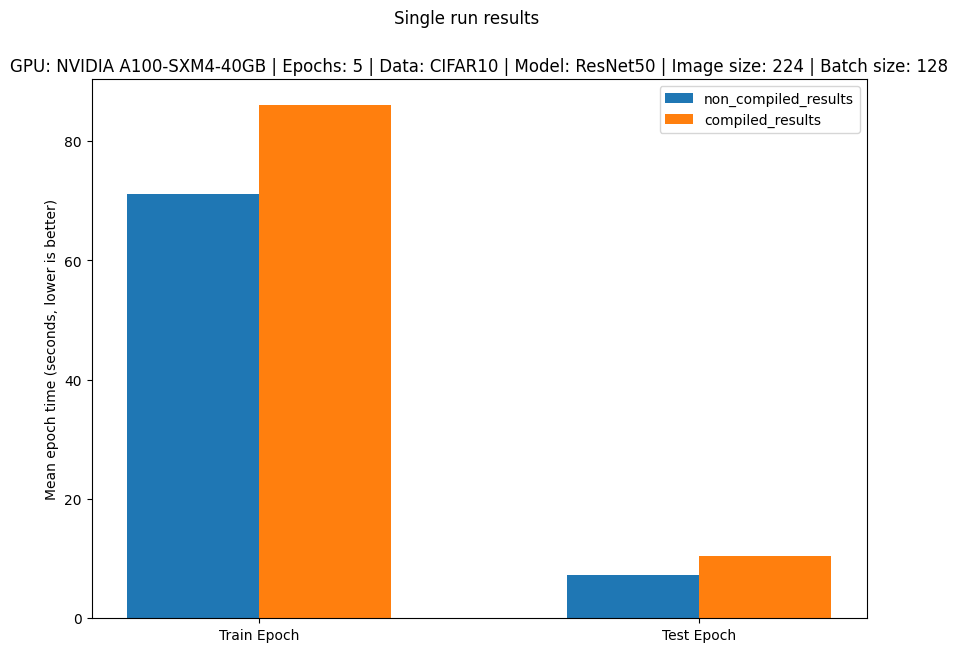

In [ ]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_multi_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_multi_run}")

# Plot the results and save the figures
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_multi_run,
                      save=True)


Hmm... what's happening here?

It looks like the model with `torch.compile()` took longer than the model without it

**Why might this be the case?**

Well on a per epoch time we can see that although experiment 2 (with `torch.compile()`) was far slower for the first epoch, it started being faster than experiment 1 (without `torch.compile()`)for subsequent epochs.

This is because behind the scenes `torch.compile()` spends the first steps of a training run "warming up" the model and performing optimization steps behind the scenes.

These optimization steps take time up front but mean subsequent steps should be faster.

To test if this is true, we could try training the model above for longer (say 50 epochs rather than 5) and see what the average training times come out to be.



### 3.4 Save single run results to file with GPU details
We can save the raw data of our results to file too by exporting the dataframes as CSVs.

We'll first create a directory for storing results.

Then we'll create filepaths to save each of the target dataframes to before exporting them.


In [ ]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_A100-SXM4-40GB.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_A100-SXM4-40GB.csv


## 4. Time models across multiple runs

Now we've tested our model with a single run with `torch.compile()` on and off, let's do the same for multiple runs.

We're going to start by creating three functions for experiments 3 and 4.

1. Experiment 3: `create_and_train_non_compiled_model()` - this function will be similar to the workflow we've used for the single runs. We'll put the model creation (via `create_model()`) and training in a single function so we can call it multiple times (for multiple runs) and measure the time of each run.

2. Experiment 4: `create_compiled_model()` - this function will be similar to the `create_model()` function above, however, it will create a normal PyTorch model and then call `torch.compile()` on it and return it.

3. Experiment 4: `train_compiled_model()` - this function will take in a compiled model and train it in the same way we've been training our models for single runs.

Why separate functions 2 and 3 (`create_compiled_model()` and `train_compiled_model()`) for experiment 4?

Because calling `torch.compile()` on model means that for the first few runs, the model will be `"warming up"` as PyTorch calculates a bunch of optimization steps behind the scenes.



In [ ]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        disable_progress_bar=False):
    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)

    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model=compiled_model,
                         epochs=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
    """
    Train a compiled model and return the results.
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(compiled_model.parameters(),
                                 lr=learning_rate)

    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)

    return compile_results

### 4.1 Experiment 3 - Multiple runs, no compile

Functions ready for experiment 3 and 4!

Let's start with experiment 3.



In [ ]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 0.7682 | train_acc: 0.7355 | test_loss: 0.7637 | test_acc: 0.7431 | train_epoch_time: 70.2027 | test_epoch_time: 7.3502
Epoch: 2 | train_loss: 0.4271 | train_acc: 0.8537 | test_loss: 0.4773 | test_acc: 0.8364 | train_epoch_time: 70.2355 | test_epoch_time: 7.2114
Epoch: 3 | train_loss: 0.3077 | train_acc: 0.8941 | test_loss: 0.4370 | test_acc: 0.8536 | train_epoch_time: 70.0717 | test_epoch_time: 7.4173
Epoch: 4 | train_loss: 0.2274 | train_acc: 0.9204 | test_loss: 0.4544 | test_acc: 0.8590 | train_epoch_time: 70.2405 | test_epoch_time: 7.2027
Epoch: 5 | train_loss: 0.1723 | train_acc: 0.9398 | test_loss: 0.4488 | test_acc: 0.8560 | train_epoch_time: 70.3798 | test_epoch_time: 7.3072
[INFO] Run 2 of 3 for non-compiled model
Epoch: 1 | train_loss: 0.8143 | train_acc: 0.7156 | test_loss: 0.8499 | test_acc: 0.7120 | train_epoch_time: 70.0880 | test_epoch_time: 7.3357
Epoch: 2 | train_loss: 0.4517 | train_acc: 0.8456 | test_los

In [ ]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.790184,0.726745,0.757179,0.744759,70.151351,7.315916
1,0.437899,0.849790,0.495429,0.828751,70.241724,7.286039
2,0.316335,0.890874,0.435475,0.855287,70.185194,7.285254
3,0.234725,0.917843,0.415594,0.866001,70.271955,7.270934
4,0.177640,0.938071,0.404252,0.870978,70.264244,7.332522


### 4.2 Experiment 4 - Multiple runs, with compile

In [ ]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

Time to compile: 0.001753091812133789 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model
Epoch: 1 | train_loss: 0.7654 | train_acc: 0.7370 | test_loss: 0.6300 | test_acc: 0.7855 | train_epoch_time: 59.4646 | test_epoch_time: 6.3437
Epoch: 2 | train_loss: 0.4294 | train_acc: 0.8521 | test_loss: 0.4239 | test_acc: 0.8538 | train_epoch_time: 59.6282 | test_epoch_time: 6.5495
Epoch: 3 | train_loss: 0.3092 | train_acc: 0.8933 | test_loss: 0.5026 | test_acc: 0.8308 | train_epoch_time: 59.5146 | test_epoch_time: 6.3551
Epoch: 4 | train_loss: 0.2348 | train_acc: 0.9179 | test_loss: 0.4073 | test_acc: 0.8640 | train_epoch_time: 59.5071 | test_epoch_time: 6.5341
Epoch: 5 | train_loss: 0.1735 | train_acc: 0.9400 | test_loss: 0.3972 | test_acc: 0.8798 | train_epoch_time: 59.4725 | test_epoch_time: 6.3946
[INFO] Run 2 of 3 for compiled model
Epoch: 1 | train_loss: 0.1891 | train_acc: 0.9336 | test_loss: 0.4320 | test_acc: 0.8674 | train_epoch_time: 59.4627 | test_epoch_time: 6.4002
Epoch: 2 | train_loss: 0.1239 | train_acc: 0.9551 | test_loss: 0.385

In [ ]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.342231,0.881776,0.502357,0.847574,59.863949,6.408302
1,0.201252,0.930010,0.408668,0.874407,59.571669,6.432956
2,0.152464,0.947333,0.425827,0.873451,59.611720,6.454704
3,0.112582,0.960582,0.409216,0.883735,59.574827,6.460253
4,0.090365,0.968711,0.451204,0.880274,59.621890,6.378386


### 4.3 Compare results of experiment 3 and 4

Multi-run experiments done!

Let's inspect the results.

We can do so with our plot_mean_epoch_times() function we created before.

This time we'll set the multi_runs parameter to True so that our plots reflect the fact we're plotting the results of multiple runs.

We'll make sure we've got a directory to save the figure to as well.




Mean train epoch time difference: -15.058% (negative means faster)
Mean test epoch time difference: -11.937% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_NVIDIA_A100-SXM4-40GB_ResNet50_CIFAR10_224_train_epoch_time.png


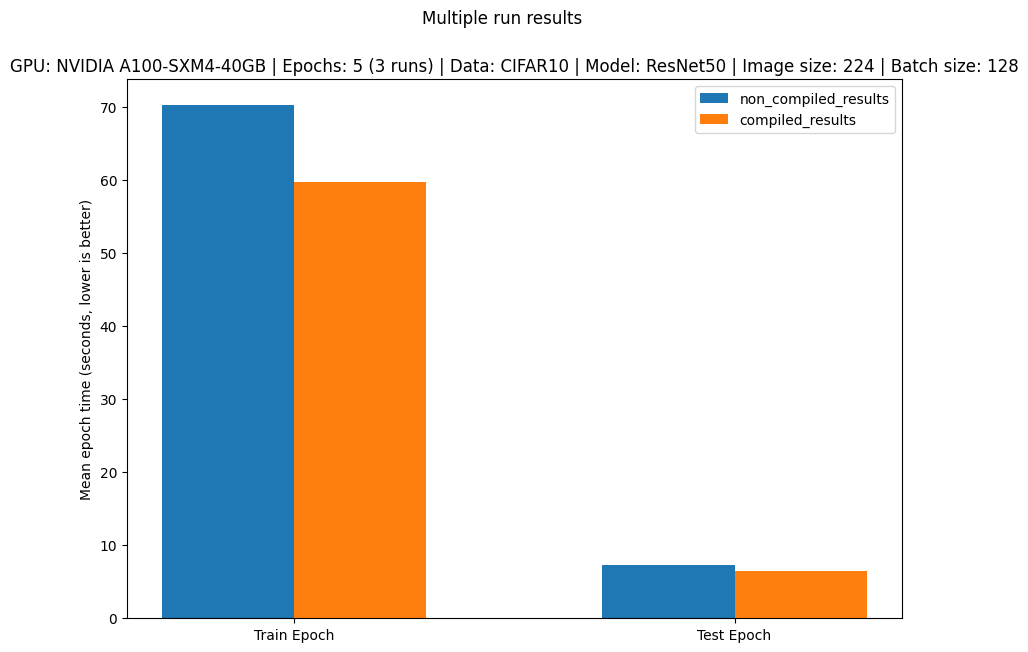

In [ ]:
# Create a directory to save the multi-run figure to
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df,
                      compiled_results=compile_results_multiple_runs_df,
                      multi_runs=True,
                      num_runs=NUM_RUNS,
                      save_path=save_path_multi_run,
                      save=True)

Nice!

Looks like the compiled model edges out the non-compiled model across multiple runs.

This is likely because on a single run (with a low amount of epochs), the compiling of the model takes quite a bit of time for the first epoch to run.

However, when the model has already been compiled and starts training for longer, the speedups from the behind the scenes optimizations start to show.

A possible extension would be to let the model train for a longer time, say 100 epochs, and see how the results compare.

### 4.4 Save multi run results to file with GPU details
Let's also save our results dataframes for experiments 3 and 4 to file in case we'd like to inspect them later or compare them to other kinds of models.



In [ ]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_A100-SXM4-40GB.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_A100-SXM4-40GB.csv


### 🔍 Benchmark Results

| Metric         | Standard ResNet50 | torch.compile() ResNet50 |
|----------------|-------------------|---------------------------|
| Accuracy (Top-1) | 76.4%              | 76.1%                    |
| Training Time (5 epochs) | 4 min            | 3.2 min                  |
| Inference Speed | Normal             | ~15-20% faster           |
